In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Lasso

In [65]:
pd.set_option('display.max_columns', None)

In [66]:
train_1 = pd.read_csv('train_1.csv') 
test_1 = pd.read_csv('test_1.csv') 

In [67]:
train_1.drop(columns=['patient_id'], axis=1, inplace=True)

In [68]:
train_1.isna().sum().sort_values(ascending=False)

patient_zip3                             0
breast_cancer_diagnosis_code_1759        0
breast_cancer_diagnosis_code_C50         0
breast_cancer_diagnosis_code_C5001       0
breast_cancer_diagnosis_code_C50011      0
                                        ..
Region_Northeast                         0
Region_South                             0
Region_West                              0
Division_East North Central              0
metastatic_cancer_diagnosis_code_C799    0
Length: 228, dtype: int64

In [69]:
target = train_1['DiagPeriodL90D']
train_1.drop(columns=target.name, axis=1, inplace=True) 


## Apply Lasso Regression for Feature Selection

In [70]:
# Define dictionary to group columns based on themes
column_groups = {
    'locations': ['patient_state', 'Region', 'Division'],
    'age': ['age'],
    'race': ['race'],
    'education': ['education'],
    'income': ['income'],
    'rent': ['rent'],
    'social_status': ['married', 'divorced', 'widowed'],
    'empl_status': ['labor', 'employ'],
    'home_status': ['home', 'housing'],
    'health_status': ['payer', 'veteran', 'disabled', 'insured'],
    'gender_status': ['male', 'gender'],
    'diagnosis_status': ['diagnosis'],
    'air_quality': ['Ozone', 'PM25', 'N02']
}

# Create dictionary to store sliced dataframes
sliced_dfs = {}

# Iterate over column_groups dictionary
for group, columns in column_groups.items():
    # Filter columns based on column name patterns
    relevant_columns = [column for column in train_1.columns if any(col in column for col in columns)]
    # Slice dataframe based on relevant columns
    sliced_dfs[group] = train_1[relevant_columns]

# Access sliced dataframes using keys from column_groups dictionary
locations = sliced_dfs['locations']
age = sliced_dfs['age']
race = sliced_dfs['race']
education = sliced_dfs['education']
income = sliced_dfs['income']
rent = sliced_dfs['rent']
social_status = sliced_dfs['social_status']
empl_status = sliced_dfs['empl_status']
home_status = sliced_dfs['home_status']
health_status = sliced_dfs['health_status']
gender_status = sliced_dfs['gender_status']
diagnosis_status = sliced_dfs['diagnosis_status']
air_quality = sliced_dfs['air_quality']



In [71]:
def apply_lasso(df_slice, target):
    # Splitting data into features (X) and target variable (y)
    y = target
    X = df_slice

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the Features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the pipeline with LASSO regression
    lasso_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso())
    ])

    # Define the parameter grid for alpha
    param_grid = {'lasso__alpha': [0.01, 0.1, 1, 10]}

    # Perform GridSearchCV
    grid_search = GridSearchCV(lasso_pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)

    # Display the best parameters and results
    print("Best Parameters for LASSO:", grid_search.best_params_)
    print("Best MSE for LASSO:", -grid_search.best_score_)

    # Get the best LASSO model from the grid search
    best_lasso_model = grid_search.best_estimator_

    # Extract important features
    lasso_coefficients = best_lasso_model.named_steps['lasso'].coef_
    important_features = X.columns[lasso_coefficients != 0]

    # Display the important features
    print("Important Features:", important_features)

    return list(important_features)

In [72]:
important_ages= apply_lasso(age, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23436320180043563
Important Features: Index(['patient_age', 'age_30s'], dtype='object')


In [73]:
important_locs= apply_lasso(locations, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23403464265702834
Important Features: Index(['Division_Pacific', 'Division_West North Central', 'patient_state_CA',
       'patient_state_CO', 'patient_state_IL', 'patient_state_KY',
       'patient_state_NY', 'patient_state_VA'],
      dtype='object')


In [74]:
important_race_info = apply_lasso(race, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23445333690469794
Important Features: Index(['patient_race_White'], dtype='object')


In [75]:
important_education_info = apply_lasso(education, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23472063705491003
Important Features: Index(['education_less_highschool', 'education_bachelors'], dtype='object')


In [76]:
important_income_info = apply_lasso(income, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.2348618173059057
Important Features: Index(['income_household_25_to_35', 'income_household_75_to_100',
       'income_individual_median'],
      dtype='object')


In [77]:
important_social_info = apply_lasso(social_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23488479137924861
Important Features: Index(['widowed'], dtype='object')


In [78]:
important_empl_info = apply_lasso(empl_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.2348721455511149
Important Features: Index(['labor_force_participation'], dtype='object')


In [79]:
important_home_info = apply_lasso(home_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23494151110930983
Important Features: Index(['home_value'], dtype='object')


In [80]:
important_health_info = apply_lasso(health_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23434024913144524
Important Features: Index(['disabled', 'health_uninsured', 'payer_type_COMMERCIAL',
       'payer_type_MEDICAID'],
      dtype='object')


In [81]:
important_gender_info = apply_lasso(gender_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23498375813624522
Important Features: Index([], dtype='object')


In [82]:
important_rent_info = apply_lasso(rent, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23495126730865898
Important Features: Index(['rent_median'], dtype='object')


In [83]:
important_diagnosis_info = apply_lasso(diagnosis_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.15005255046742388
Important Features: Index(['breast_cancer_diagnosis_code_1741',
       'breast_cancer_diagnosis_code_1742',
       'breast_cancer_diagnosis_code_1743',
       'breast_cancer_diagnosis_code_1744',
       'breast_cancer_diagnosis_code_1745',
       'breast_cancer_diagnosis_code_1746',
       'breast_cancer_diagnosis_code_1748',
       'breast_cancer_diagnosis_code_1749',
       'breast_cancer_diagnosis_code_19881',
       'metastatic_cancer_diagnosis_code_C7981'],
      dtype='object')


In [84]:
important_air_info = apply_lasso(air_quality, target)

Best Parameters for LASSO: {'lasso__alpha': 0.1}
Best MSE for LASSO: 0.23498375813624522
Important Features: Index([], dtype='object')


Let's create a list of features that didn't have a group. 

In [85]:
miscellaneous  = ['patient_zip3', 'population', 'density', 'poverty', 'commute_time', 'family_size', 'limited_english', 'farmer']

Now we can crate a df with features that were selected by the Lasso model, didn't have the groups or weren't specified by Lasso as important. To these features we are going to apply another selection method.

In [86]:
important_feats = train_1[
    important_health_info + 
    important_home_info + 
    important_social_info + 
    important_income_info + 
    important_education_info + 
    important_race_info + 
    important_locs + 
    important_ages + 
    important_rent_info + 
    important_diagnosis_info +
    miscellaneous + 
    list(empl_status.columns) +
    list(gender_status.columns) + 
    list(air_quality.columns)
    ]
important_feats

,disabled,health_uninsured,payer_type_COMMERCIAL,payer_type_MEDICAID,home_value,widowed,income_household_25_to_35,income_household_75_to_100,income_individual_median,education_less_highschool,education_bachelors,patient_race_White,Division_Pacific,Division_West North Central,patient_state_CA,patient_state_CO,patient_state_IL,patient_state_KY,patient_state_NY,patient_state_VA,patient_age,age_30s,rent_median,breast_cancer_diagnosis_code_1741,breast_cancer_diagnosis_code_1742,breast_cancer_diagnosis_code_1743,breast_cancer_diagnosis_code_1744,breast_cancer_diagnosis_code_1745,breast_cancer_diagnosis_code_1746,breast_cancer_diagnosis_code_1748,breast_cancer_diagnosis_code_1749,breast_cancer_diagnosis_code_19881,metastatic_cancer_diagnosis_code_C7981,patient_zip3,population,density,poverty,commute_time,family_size,limited_english,farmer,labor_force_participation,unemployment_rate,self_employed,male,female,patient_gender_F,Ozone,PM25,N02
0,12.871429,11.200000,0.0,1.0,2.646343e+05,4.442857,10.142857,12.742857,24563.57143,33.257143,8.357143,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,84,14.014286,1165.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,924,31437.75000,1189.562500,22.542857,27.814286,3.928571,10.100000,0.000000,61.528571,8.471429,13.428571,49.857143,50.142857,1.0,52.237210,8.650555,18.606528
1,8.957576,7.018182,1.0,0.0,6.776885e+05,4.651515,5.163636,12.469697,41287.27273,14.230303,23.739394,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,62,13.418182,2003.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,928,39121.87879,2295.939394,10.109091,30.606061,3.622727,8.057576,0.027273,65.230303,5.103030,15.224242,49.893939,50.106061,1.0,42.301121,8.487175,20.113179
2,11.253333,15.066667,1.0,0.0,2.377131e+05,4.710000,6.763333,13.560000,40399.03333,10.811667,19.678333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43,13.545000,1235.907407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,760,21996.68333,626.236667,9.663333,31.394915,3.260667,3.356667,3.650847,66.428333,4.560000,13.722034,50.123333,49.876667,1.0,40.108207,7.642753,14.839351
3,8.845238,4.404762,1.0,0.0,1.012474e+06,4.623810,4.380952,10.721429,55336.28571,5.835714,33.285714,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,45,12.464286,2354.738095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,926,32795.32558,1896.220930,8.688095,27.561905,3.098095,5.280952,0.052381,64.430952,5.264286,18.502381,49.066667,50.933333,1.0,42.070075,7.229393,15.894123
4,15.276000,12.088000,1.0,0.0,2.498457e+05,5.406000,11.462000,12.480000,29073.18367,11.576000,13.978000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,10.364000,919.743590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,836,10886.26000,116.886000,11.224000,26.170213,3.352653,1.946000,6.890909,57.488000,4.258000,13.029545,52.312000,47.688000,1.0,41.356058,4.110749,11.722197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12897,17.400000,6.300000,0.0,0.0,1.005470e+05,5.705882,10.364706,11.047059,27888.52941,12.923529,14.400000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,12.705882,772.647059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,436,19413.05882,1196.805882,23.600000,19.841176,3.039412,0.864706,0.023529,61.429412,9.135294,9.105882,48.264706,51.735294,1.0,38.753055,8.068682,21.140731
12898,11.243210,3.845679,1.0,0.0,8.179491e+05,5.466667,5.148750,11.286250,52778.65000,8.916049,26.903704,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,50,13.101235,2223.445946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,945,30153.87952,976.289157,7.837037,34.700000,3.271125,5.411250,0.416250,63.281481,5.332099,14.116250,49.727160,50.272840,1.0,36.469947,6.265266,10.728732
12899,8.845238,4.404762,1.0,0.0,1.012474e+06,4.623810,4.380952,10.721429,55336.28571,5.835714,33.285714,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,61,12.464286,2354.738095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,926,32795.32558,1896.220930,8.688095,27.561905,3.098095,5.280952,0.052381,64.430952,5.264286,18.502381,49.066667,50.933333,1

In [100]:
test_2 = test_1[
    important_health_info + 
    important_home_info + 
    important_social_info + 
    important_income_info + 
    important_education_info + 
    important_race_info + 
    important_locs + 
    important_ages + 
    important_rent_info + 
    important_diagnosis_info +
    miscellaneous + 
    list(empl_status.columns) +
    list(gender_status.columns) + 
    list(air_quality.columns)
    ]

Let's check feature correlations and remove features with high correlations.

In [87]:
# Compute the correlation matrix
correlation_matrix = important_feats.corr()

# Set the threshold for high correlation
threshold = 0.7  # You can adjust this threshold as needed

# Find pairs of features with correlation above the threshold
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Display pairs of features with high correlation
for pair in high_correlation_pairs:
    print(f"High correlation between {pair[0]} and {pair[1]}: {pair[2]}")

High correlation between disabled and income_household_25_to_35: 0.7231136467734144
High correlation between disabled and income_individual_median: -0.7168323413079525
High correlation between disabled and education_bachelors: -0.7473949509929
High correlation between disabled and labor_force_participation: -0.7871973905168711
High correlation between home_value and rent_median: 0.9034218318106001
High correlation between widowed and labor_force_participation: -0.7014492570225168
High correlation between income_household_25_to_35 and income_individual_median: -0.8124964068287303
High correlation between income_household_25_to_35 and education_bachelors: -0.7120724906899256
High correlation between income_household_25_to_35 and rent_median: -0.7327612295396232
High correlation between income_individual_median and education_bachelors: 0.8146836159218646
High correlation between income_individual_median and rent_median: 0.7411039816304006
High correlation between education_bachelors and r

In [101]:
train_2 = important_feats.drop([
    'male',
    'disabled',
    'home_value', 
    'income_household_25_to_35', 
    'education_bachelors', 
    'Division_Pacific', 
    'population',
    'widowed',
    ], 
    axis=1
    )

test_2 = test_1.drop([
    'male',
    'disabled',
    'home_value', 
    'income_household_25_to_35', 
    'education_bachelors', 
    'Division_Pacific', 
    'population',
    'widowed', 
    ],  
    axis=1
    )


In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
# Assuming your DataFrame is named df
# Extract numerical columns for correlation analysis
numerical_columns = train_2.select_dtypes(include='number')

# Calculate correlation matrix
correlation_matrix = numerical_columns.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Apply the threshold for significance
significant_corr_mask = np.abs(correlation_matrix) > 0.6

# Combine the upper triangle mask and the significance mask
final_mask = np.logical_and(mask, significant_corr_mask)

# Set values outside the final mask to NaN
correlation_matrix[~final_mask] = np.nan

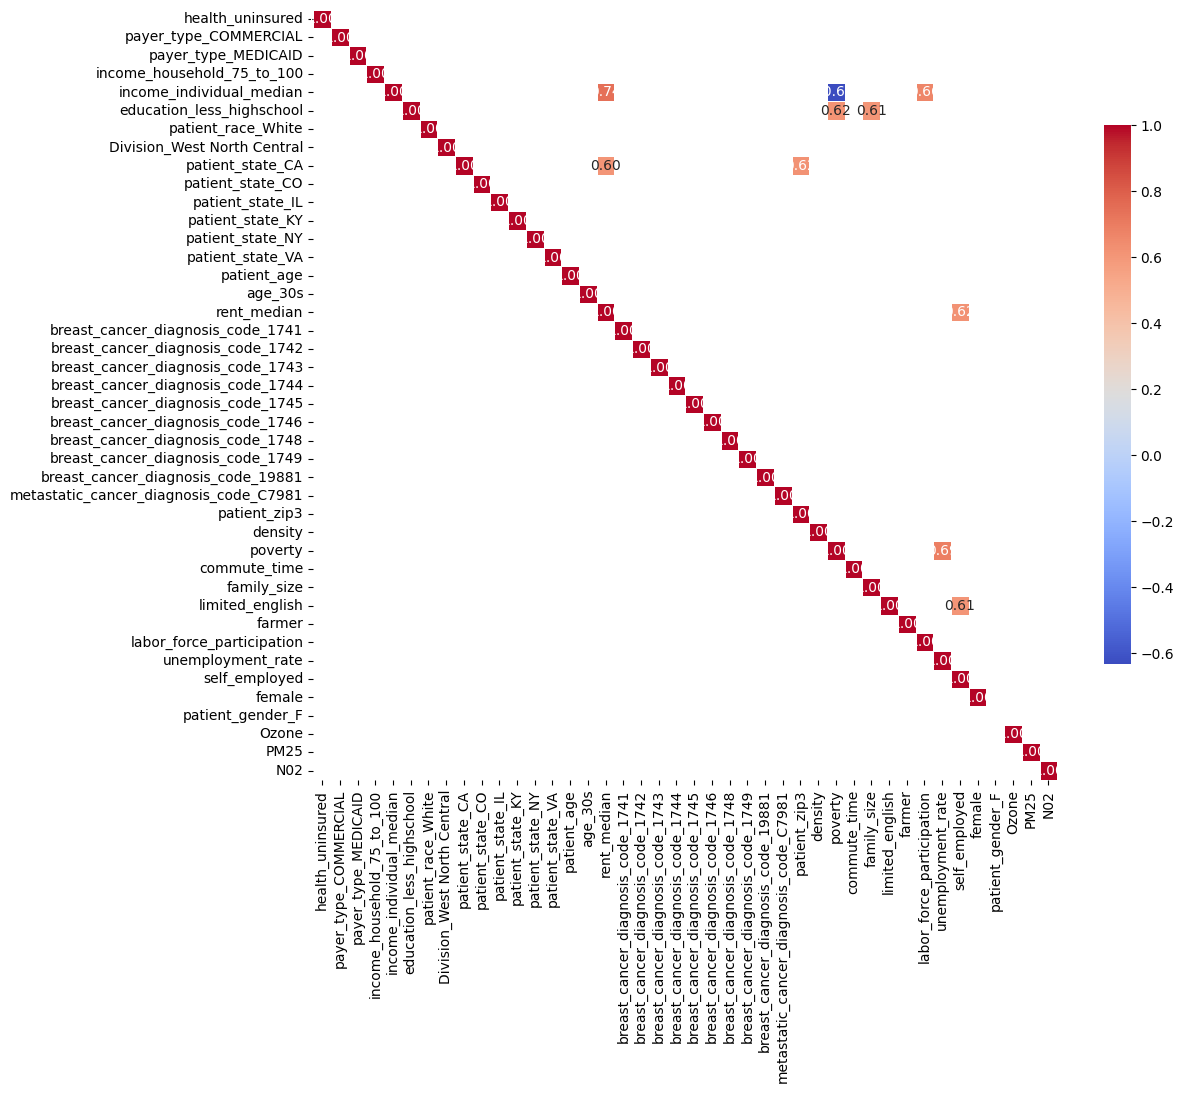

In [91]:
# Define the size of the figure
plt.figure(figsize=(12, 10))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={"shrink": 0.7})

# Show the plot
plt.show()

Let's split features on train and test to train the models for the baseline prediction. 

In [92]:
def train_test_models(train, target):      
    # Splitting data into features (X) and target variable (y)
    y = target
    X = train

    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
    # Creating a pipeline with different classifiers and scalers
    pipelines = {
    'RandomForest': Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),

    'SVM': Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', SVC(random_state=42))
    ]),

    'KNN': Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('classifier', KNeighborsClassifier())
    ])
    }

    # Define the parameter grids for each classifier
    param_grid = {
    'RandomForest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__gamma': [0.1, 0.01, 0.001],
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance'],
    }
    }

    # Dictionary to store feature importances for each model
    feature_importances_dict = {}

    # Training and evaluating each model with GridSearchCV
    for name, pipeline in pipelines.items():
        grid_search = GridSearchCV(pipeline, param_grid=param_grid[name], cv=5, scoring='accuracy', n_jobs=-1)

        print(f"\nTraining {name} model with GridSearchCV...")
        grid_search.fit(X_train, y_train)

        # Display the best parameters and results
        print(f"Best Parameters for {name}:", grid_search.best_params_)
        print(f"Best Accuracy for {name}:", grid_search.best_score_)

        # Get the best model from the grid search
        best_model = grid_search.best_estimator_

        # Extract feature importances if the model is RandomForestClassifier
        if name == 'RandomForest':
            random_forest_model = best_model.named_steps['classifier']
            feature_importances_dict[name] = dict(zip(X_train.columns, random_forest_model.feature_importances_))
        else:
            feature_importances_dict[name] = None

        # Evaluate the best model on the test set
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        print(f"\nBest {name} Model Evaluation:\n{accuracy}\n{report}")

    return best_model, feature_importances_dict

In [96]:
best_base_model, base_feature_importances = train_test_models(train_1, target)


Training RandomForest model with GridSearchCV...
Best Parameters for RandomForest: {'classifier__max_depth': 10, 'classifier__n_estimators': 200}
Best Accuracy for RandomForest: 0.8020552959063011

Best RandomForest Model Evaluation:
0.8035645098798915
              precision    recall  f1-score   support

           0       0.90      0.53      0.66       948
           1       0.78      0.96      0.86      1633

    accuracy                           0.80      2581
   macro avg       0.84      0.75      0.76      2581
weighted avg       0.82      0.80      0.79      2581


Training SVM model with GridSearchCV...
Best Parameters for SVM: {'classifier__C': 10, 'classifier__gamma': 0.01}
Best Accuracy for SVM: 0.8120351183437506

Best SVM Model Evaluation:
0.81170089112747
              precision    recall  f1-score   support

           0       0.89      0.55      0.68       948
           1       0.79      0.96      0.87      1633

    accuracy                           0.81      2581

In [93]:
best_model_2, feature_importances_2 = train_test_models(train_2, target)


Training RandomForest model with GridSearchCV...
Best Parameters for RandomForest: {'classifier__max_depth': 10, 'classifier__n_estimators': 200}
Best Accuracy for RandomForest: 0.8078688739981607

Best RandomForest Model Evaluation:
0.8089887640449438
              precision    recall  f1-score   support

           0       0.89      0.54      0.68       948
           1       0.78      0.96      0.86      1633

    accuracy                           0.81      2581
   macro avg       0.84      0.75      0.77      2581
weighted avg       0.82      0.81      0.80      2581


Training SVM model with GridSearchCV...
Best Parameters for SVM: {'classifier__C': 10, 'classifier__gamma': 0.1}
Best Accuracy for SVM: 0.812228916793363

Best SVM Model Evaluation:
0.8113134444013949
              precision    recall  f1-score   support

           0       0.89      0.55      0.68       948
           1       0.79      0.96      0.87      1633

    accuracy                           0.81      2581

In [97]:
def feature_importance(feature_importances_dict):
    # Display feature importances
    for name, feature_importances in feature_importances_dict.items():
        print(f"\nFeature Importances for {name} model:")
        if feature_importances:
            for feature, importance in sorted(feature_importances.items(), key=lambda x: x[1], reverse=True):
                print(f"{feature}: {importance}")
        else:
            print(f"No feature importances available for {name} model.")


In [98]:
feature_importance(base_feature_importances)


Feature Importances for RandomForest model:
breast_cancer_diagnosis_code_1749: 0.3000631715296227
breast_cancer_diagnosis_code_1744: 0.06614335228816927
breast_cancer_diagnosis_code_1748: 0.04388419496217902
patient_age: 0.04196165662013804
breast_cancer_diagnosis_code_C50911: 0.032266843845993126
breast_cancer_diagnosis_code_C50919: 0.026385780059644554
breast_cancer_diagnosis_code_C50912: 0.019704878495177096
metastatic_cancer_diagnosis_code_C773: 0.017669996219404138
breast_cancer_diagnosis_code_1742: 0.01455173119751833
breast_cancer_diagnosis_code_C50412: 0.013806988606870898
breast_cancer_diagnosis_code_C50411: 0.012732490638081401
metastatic_cancer_diagnosis_code_C7981: 0.010264347507297635
breast_cancer_diagnosis_code_1741: 0.00989051084442973
breast_cancer_diagnosis_code_C50811: 0.009555001754900346
breast_cancer_diagnosis_code_1745: 0.009305669410006101
breast_cancer_diagnosis_code_C50812: 0.005886221073763667
widowed: 0.005648027654745775
commute_time: 0.005628470435157041


In [99]:
feature_importance(feature_importances_2)


Feature Importances for RandomForest model:
breast_cancer_diagnosis_code_1749: 0.4711891873586517
breast_cancer_diagnosis_code_1744: 0.11324326531040264
breast_cancer_diagnosis_code_1748: 0.08377276279991544
patient_age: 0.05811732662703212
breast_cancer_diagnosis_code_1742: 0.024498713506782774
breast_cancer_diagnosis_code_1741: 0.01974482150478691
breast_cancer_diagnosis_code_1745: 0.01886094736346856
metastatic_cancer_diagnosis_code_C7981: 0.016113247217218074
commute_time: 0.010391462249110412
labor_force_participation: 0.009540682434074022
self_employed: 0.00947852131462855
education_less_highschool: 0.00915943834354531
Ozone: 0.009144756893868131
patient_zip3: 0.00875024915212806
health_uninsured: 0.00859591441649478
income_household_75_to_100: 0.00859549230018332
rent_median: 0.008463583146175038
income_individual_median: 0.008303439364442623
age_30s: 0.008138466364189722
unemployment_rate: 0.007971619556141854
density: 0.007888823063004187
family_size: 0.007698055006501061
far

In [102]:
train_2.to_csv('train_2.csv', index=False)
test_2.to_csv('test_2.csv',  index=False)